---

# Исследовательский анализ глобальной базы по поверке метеостанций

Импортируем библиотеки:

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

Загрузим данные и необходимые поля:

In [10]:
df = pd.read_excel('data/all_data.xlsx', usecols=[
    'mi.mitnumber',
    'mi.modification',
    'mi.number',
    'valid_date',
    'result_docnum',
    'result_text',
    'mi.mitype',
    'mi.mititle',
    'org_title',
    'vri_id',
    'verification_date'
])

Выведем первые пять строк и основную информацию о датафрейме:

In [11]:
df.head()

,mi.mitnumber,mi.modification,mi.number,valid_date,result_docnum,result_text,mi.mitype,mi.mititle,org_title,vri_id,verification_date
0,40331-14,Vantage Pro2,BF200803012,2024-10-16T00:00:00Z,С-ДЮП/17-10-2023/287418480,Пригодно,Vantage Pro2,Станции автоматические метеорологические,ООО «ПРОММАШ ТЕСТ МЕТРОЛОГИЯ»,1-287418480,2023-10-17T00:00:00Z
1,76239-19,СОКОЛ-М1,MSL0320000336,2025-10-15T00:00:00Z,С-ВАМ/16-10-2023/287158218,Пригодно,СОКОЛ-М1,Станции автоматические метеорологические,"ФГБУ ""УГМС РЕСПУБЛИКИ ТАТАРСТАН""",1-287158218,2023-10-16T00:00:00Z
2,40331-14,Vantage Pro2,BF230221033,2024-10-12T00:00:00Z,С-ДЮП/13-10-2023/286964248,Пригодно,Vantage Pro2,Станции автоматические метеорологические,ООО «ПРОММАШ ТЕСТ МЕТРОЛОГИЯ»,1-286964248,2023-10-13T00:00:00Z
3,40331-14,Vantage Pro2,BE181206037,2024-10-12T00:00:00Z,С-ТТ/13-10-2023/286487854,Пригодно,Vantage Pro2,Станции автоматические метеорологические,"ФБУ ""РОСТЕСТ-МОСКВА""",1-286487854,2023-10-13T00:00:00Z
4,23266-06,М-49М,100,2024-10-12T00:00:00Z,С-ДЮП/13-10-2023/286525277,Пригодно,М-49М,Станции метеорологические,ООО «ПРОММАШ ТЕСТ МЕТРОЛОГИЯ»,1-286525277,2023-10-13T00:00:00Z


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8537 entries, 0 to 8536
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   mi.mitnumber       8537 non-null   object
 1   mi.modification    8162 non-null   object
 2   mi.number          8537 non-null   object
 3   valid_date         7922 non-null   object
 4   result_docnum      8537 non-null   object
 5   result_text        8537 non-null   object
 6   mi.mitype          8537 non-null   object
 7   mi.mititle         8537 non-null   object
 8   org_title          8537 non-null   object
 9   vri_id             8537 non-null   object
 10  verification_date  8537 non-null   object
dtypes: object(11)
memory usage: 733.8+ KB


Есть пропуски в полях `mi.modification` и `valid_date`. Пропуски здесь несут информацию: если поля не заполнены - у метеостанции нет наименования модификации и метеостанция не прошла поверку соответственно.

Преобразуем тип данных в полях `valid_date` и `verification_date` в `pd.datetime` без тайм-зоны:

In [15]:
df['valid_date'] = pd.to_datetime(df['valid_date']).dt.tz_localize(None)
df['verification_date'] = pd.to_datetime(df['verification_date']).dt.tz_localize(None)

Посмотрим дату первой и последней поверки метеостанций (вычислим диапазон дат поверки метеостанций в базе данных):

In [16]:
min(df['verification_date']), max(df['verification_date'])

(Timestamp('2018-02-05 12:00:00'), Timestamp('2023-10-17 00:00:00'))

Отсортируем датафрейм по `mi.number` и `verification_date` для определения первичных поверок и возраста метеостанции:

In [18]:
df = df.sort_values(by=['mi.number', 'verification_date']).copy()

Сгенерируем поле `check` - тип поверки (периодическая или первичная). Поверка является первичной, если уникальный номер метеостанции встречается впервые и результат поверки - "Пригодно", в ином случае поверка периодическая.

In [19]:
df['check'] = 'Периодическая'
first_check_mask = (df['result_text'] == 'Пригодно') & ~df.duplicated(subset='mi.number', keep='first')
df.loc[first_check_mask, 'check'] = 'Первичная'

Сгенерируем поле `station_age` - возраст метеостанции от первичной поверки в годах, будем округлять до целого.

In [20]:
first_check_date = df[first_check_mask].groupby('mi.number')['verification_date'].min()
df['station_age'] = (df['verification_date'] - df['mi.number'].map(first_check_date)).dt.days // 365

Посмотрим, сколько всего метеостанций проходили поверку:

In [21]:
df['mi.number'].value_counts()

mi.number
12              37
8               34
7               33
19              33
17              32
                ..
BF211027037      1
BF211027040      1
BF211027045      1
BF211027046      1
в.н 418381/1     1
Name: count, Length: 3649, dtype: int64

Всего 3649 метеостанций.

Напишем функцию, для создания поля с названием производителя метеостанции:

In [25]:
def rename_mitype(mitype):
    if 'Vantage Pro' in mitype:
        return 'Davis'
    elif 'WXT' in mitype:
        return 'Vaisala'
    elif 'PWS' in mitype:
        return 'ICB'
    elif 'WS-UMB' in mitype:
        return 'Lufft'
    elif 'M-49M' in mitype:
        return 'Сафоновский'
    elif 'СОКОЛ-М1' in mitype:
        return 'СОКОЛ-М1'
    return mitype


In [26]:
df['mi.manufacturer'] = df['mi.mitype'].apply(rename_mitype)

Построим круговую диаграмму с долей производителей метеостанций, проходящих поверку:

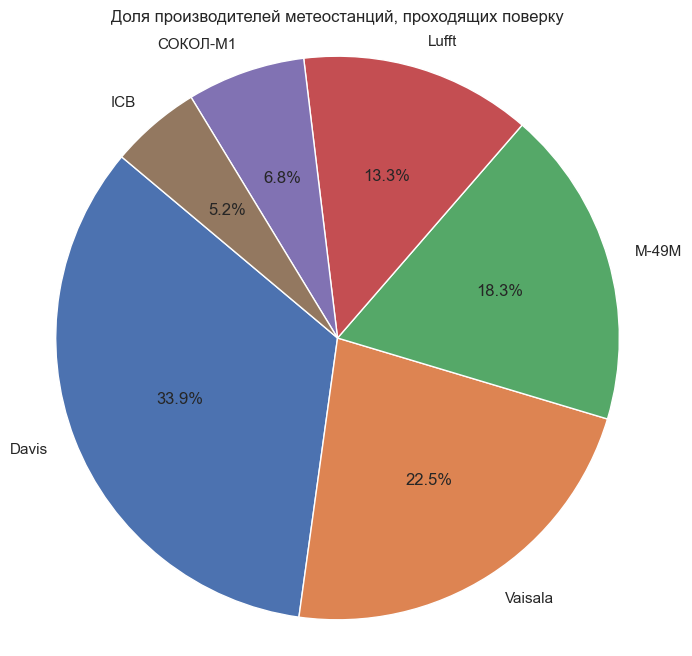

In [27]:
mi_type_counts = df['mi.manufacturer'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(mi_type_counts, labels=mi_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Доля производителей метеостанций, проходящих поверку')
plt.axis('equal') 

plt.show()

Представим в виде барового графика число поверок каждого производителя с разбивкой по типу поверки:

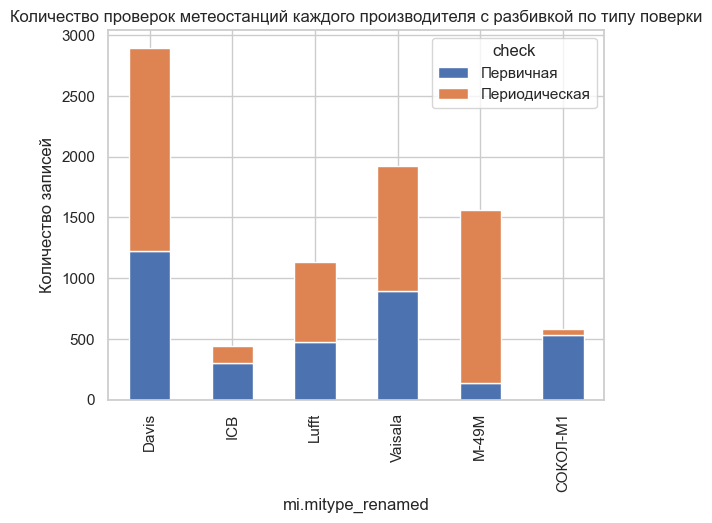

In [28]:
mi_type_check_counts = df.groupby(['mi.manufacturer', 'check']).size().unstack()
mi_type_check_counts.plot(kind='bar', stacked=True)
plt.title('Количество проверок метеостанций каждого производителя с разбивкой по типу поверки')
plt.xlabel('mi.mitype_renamed')
plt.ylabel('Количество записей')
plt.show()


Представим в виде барового графика средний возраст метеостанций каждого производителя:

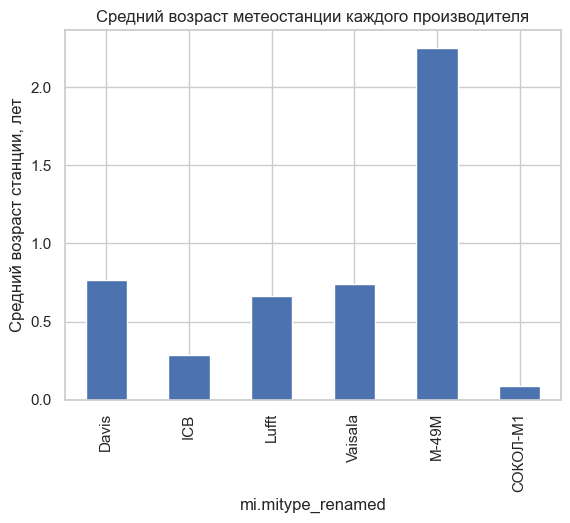

In [29]:
mi_type_avg_station_age = df.groupby('mi.manufacturer')['station_age'].mean()
mi_type_avg_station_age.plot(kind='bar')
plt.title('Средний возраст метеостанции каждого производителя')
plt.xlabel('mi.mitype_renamed')
plt.ylabel('Средний возраст станции, лет')
plt.show()


Представим распределение возраста метеостанций для каждого производителя в качестве гистограмм:

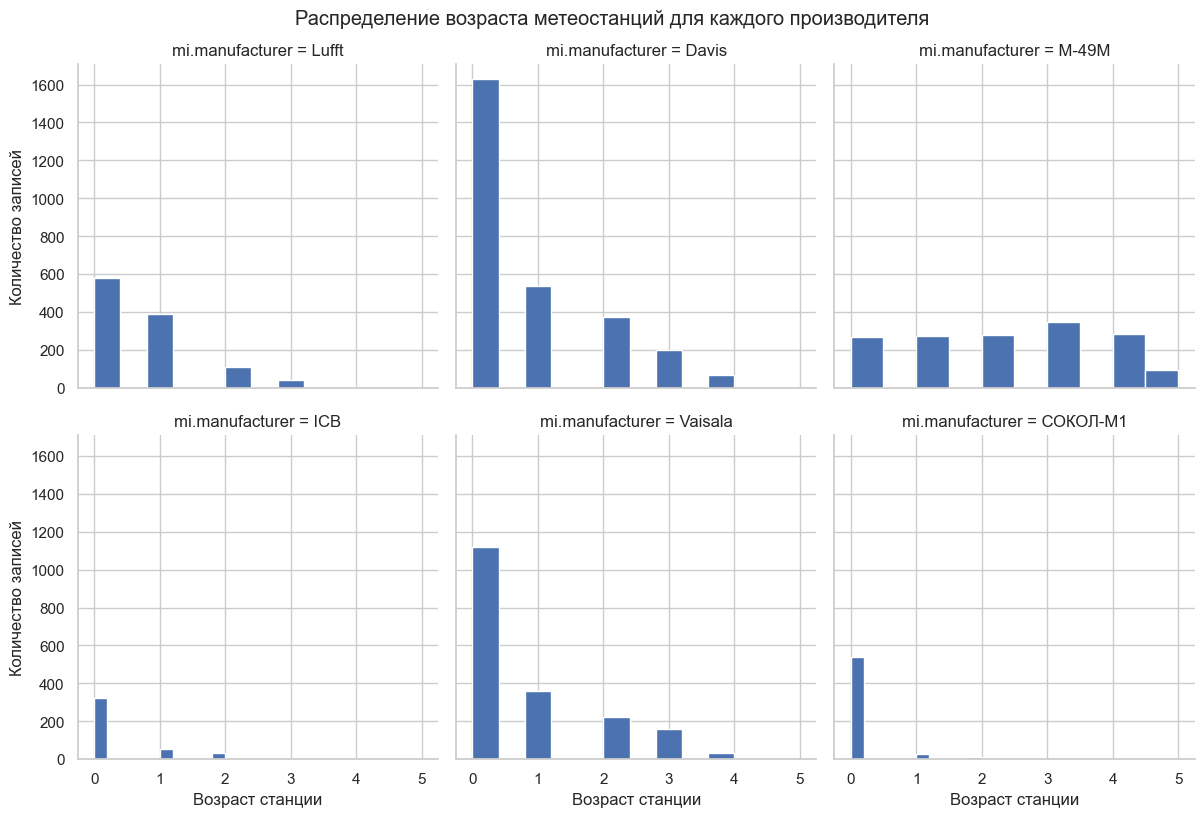

In [30]:
g = sns.FacetGrid(df, col="mi.manufacturer", height=4, col_wrap=3)
g.map(plt.hist, 'station_age', bins=10)
g.set_axis_labels('Возраст станции', 'Количество записей')
plt.suptitle('Распределение возраста метеостанций для каждого производителя', y=1.02)
plt.show()


Представим в виде тепловой карты количество поверок метеостанций каждого производителя с разбивкой по типу и результату поверки:

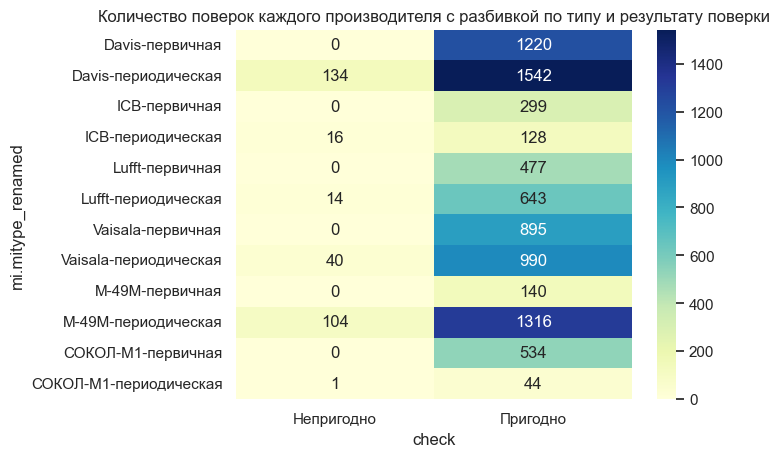

In [68]:
mi_type_check_result_counts = df.groupby(['mi.mitype_renamed', 'check', 'result_text']).size().unstack().fillna(0)

sns.heatmap(mi_type_check_result_counts, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Количество поверок каждого производителя с разбивкой по типу и результату поверки')
plt.xlabel('check')
plt.ylabel('mi.mitype_renamed')
plt.show()

И долю таких поверок:

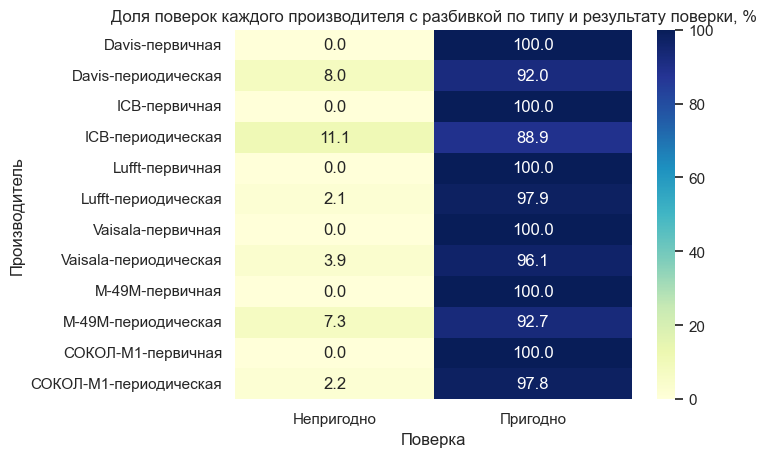

In [71]:
mi_type_check_result_percentages = mi_type_check_result_counts.div(mi_type_check_result_counts.sum(axis=1), axis=0) * 100

sns.heatmap(mi_type_check_result_percentages, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Доля поверок каждого производителя с разбивкой по типу и результату поверки, %')
plt.xlabel('Поверка')
plt.ylabel('Производитель')
plt.show()


Сохраним данные с новыми полями:

In [31]:
df.to_excel('data/all_data_with_new_columns.xlsx')

---